<a href="https://colab.research.google.com/github/GuruduttRPai/Fraud_detection/blob/main/Fraudulent_E_Commerce_Transactions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod ~/.kaggle/kaggle.json
!kaggle datasets download -d shriyashjagtap/fraudulent-e-commerce-transactions

chmod: missing operand after ‘/root/.kaggle/kaggle.json’
Try 'chmod --help' for more information.
Dataset URL: https://www.kaggle.com/datasets/shriyashjagtap/fraudulent-e-commerce-transactions
License(s): MIT
 99% 157M/159M [00:09<00:00, 18.9MB/s]
100% 159M/159M [00:09<00:00, 17.5MB/s]


In [2]:
from zipfile import ZipFile
ZipFile("/content/fraudulent-e-commerce-transactions.zip",'r').extractall()

In [3]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
import seaborn as sns

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

In [6]:
from sklearn.svm import SVC

In [7]:
from sklearn.preprocessing import LabelEncoder

In [8]:
from sklearn.metrics import confusion_matrix

In [9]:
!pip install python-Levenshtein
from Levenshtein import distance
from sklearn.metrics import f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 12.3 MB/s eta 0:00:00


In [10]:
trainData = pd.read_csv('/content/Fraudulent_E-Commerce_Transaction_Data.csv')
testData = pd.read_csv('/content/Fraudulent_E-Commerce_Transaction_Data_2.csv')

In [14]:
trainData.isnull().sum()

Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64

In [15]:
testData.isnull().sum()

Transaction ID        0
Customer ID           0
Transaction Amount    0
Transaction Date      0
Payment Method        0
Product Category      0
Quantity              0
Customer Age          0
Customer Location     0
Device Used           0
IP Address            0
Shipping Address      0
Billing Address       0
Is Fraudulent         0
Account Age Days      0
Transaction Hour      0
dtype: int64

In [11]:
trainData.head(2)

,Transaction ID,Customer ID,Transaction Amount,Transaction Date,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,IP Address,Shipping Address,Billing Address,Is Fraudulent,Account Age Days,Transaction Hour
0,15d2e414-8735-46fc-9e02-80b472b2580f,d1b87f62-51b2-493b-ad6a-77e0fe13e785,58.09,2024-02-20 05:58:41,bank transfer,electronics,1,17,Amandaborough,tablet,212.195.49.198,Unit 8934 Box 0058\nDPO AA 05437,Unit 8934 Box 0058\nDPO AA 05437,0,30,5
1,0bfee1a0-6d5e-40da-a446-d04e73b1b177,37de64d5-e901-4a56-9ea0-af0c24c069cf,389.96,2024-02-25 08:09:45,debit card,electronics,2,40,East Timothy,desktop,208.106.249.121,"634 May Keys\nPort Cherylview, NV 75063","634 May Keys\nPort Cherylview, NV 75063",0,72,8


In [12]:
froud_data = trainData[trainData['Is Fraudulent'] == 1]
not_froud_data = trainData[trainData['Is Fraudulent'] == 0]

In [13]:
trainData = pd.concat([froud_data, not_froud_data.sample(73838)], axis=0)

In [16]:
trainData['Payment Method'].value_counts()

Payment Method
debit card       37041
bank transfer    36995
credit card      36872
PayPal           36768
Name: count, dtype: int64

In [17]:
trainData['Product Category'].value_counts()

Product Category
health & beauty    29670
toys & games       29666
home & garden      29511
electronics        29486
clothing           29343
Name: count, dtype: int64

In [18]:
trainData['Customer Location'].value_counts()

Customer Location
East Michael          143
Port Michael          136
West Michael          126
Lake Michael          120
New Michael           119
                     ... 
East Beverlyfurt        1
Lake Franciscoberg      1
East Susanfurt          1
South Amberton          1
Meaganshire             1
Name: count, Length: 46537, dtype: int64

In [19]:
trainData['Device Used'].value_counts()

Device Used
mobile     49416
tablet     49205
desktop    49055
Name: count, dtype: int64

In [20]:
trainData['Is Fraudulent'].value_counts()

Is Fraudulent
1    73838
0    73838
Name: count, dtype: int64

In [21]:
drop=['Transaction ID','Customer ID','IP Address', 'Transaction Date','Shipping Address', 'Billing Address']
labelise = ['Payment Method', 'Product Category', 'Customer Location', 'Device Used']

In [22]:
def generate_labels(columns):
  label_encode = LabelEncoder()
  for column in columns:
    label_encode.fit_transform(pd.concat([ trainData[column], testData[column] ], axis=0))
    train_labels = label_encode.transform(trainData[column])
    test_labels = label_encode.transform(testData[column])

    trainData.drop(column,axis=1)
    trainData[column]=train_labels

    testData.drop(column,axis=1)
    testData[column]=test_labels


In [23]:
def fix_date_time(ds):
  ds['Transaction Month'] = pd.to_datetime(ds['Transaction Date'], format='%Y-%m-%d %H:%M:%S').dt.month
  ds.drop('Transaction Date',axis=1)

In [24]:
def calculate_address_similarity(address1, address2):

  address1 = address1.lower()
  address2 = address2.lower()
  return distance(address1, address2)/max(len(address1),len(address2))

def compare_addresses(df):
  col1_name='Shipping Address'
  col2_name='Billing Address'
  new_col_name='Shipping-Billing-Simalarity'
  df[new_col_name] = df.apply(lambda row: calculate_address_similarity(row[col1_name], row[col2_name]), axis=1)
  return df

In [25]:
generate_labels(labelise)

fix_date_time(testData)
fix_date_time(trainData)

testData=compare_addresses(testData)
trainData=compare_addresses(trainData)

trainData = trainData.drop(drop,axis=1)
testData = testData.drop(drop,axis=1)

In [26]:
froud_data = trainData[trainData['Is Fraudulent'] == 1]
not_froud_data = trainData[trainData['Is Fraudulent'] == 0]

In [27]:
trainData = pd.concat([froud_data, not_froud_data.sample(73838)], axis=0)

In [28]:
train_x = trainData.drop('Is Fraudulent',axis=1)
train_y = trainData['Is Fraudulent']
test_x = testData.drop('Is Fraudulent',axis=1)
test_y = testData['Is Fraudulent']

In [ ]:
print(train_x.shape)
print(test_x.shape)

(147676, 11)
(23634, 11)


DATA GRAPHS

<Axes: >

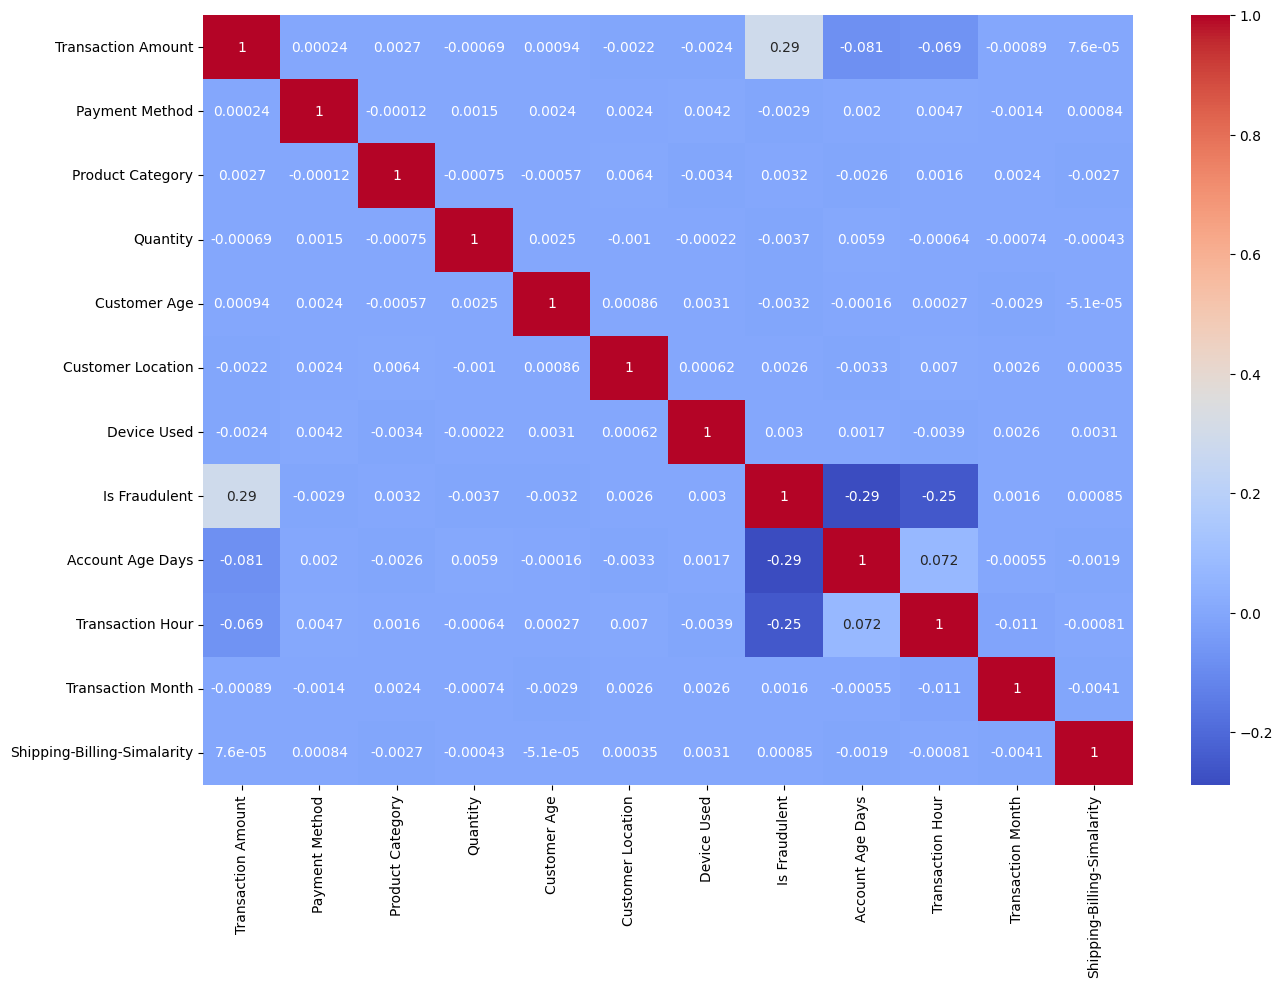

In [23]:
coor = trainData.corr()
plt.figure(figsize=(15,10))
sns.heatmap(coor, annot=True, cmap='coolwarm')

In [29]:
trainData.head(2)

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Transaction Month,Shipping-Billing-Simalarity
32,31.08,0,0,2,32,17386,2,1,147,13,1,0.0
68,839.30,1,2,2,36,39270,1,1,65,1,3,0.0


In [30]:
train_x.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,Account Age Days,Transaction Hour,Transaction Month,Shipping-Billing-Simalarity
32,31.08,0,0,2,32,17386,2,147,13,1,0.000000
68,839.30,1,2,2,36,39270,1,65,1,3,0.000000
85,379.00,3,3,4,37,3823,0,30,20,1,0.000000
92,46.26,2,0,2,30,30314,2,12,10,1,0.000000
191,2038.00,2,2,1,32,43361,1,9,17,1,0.785714


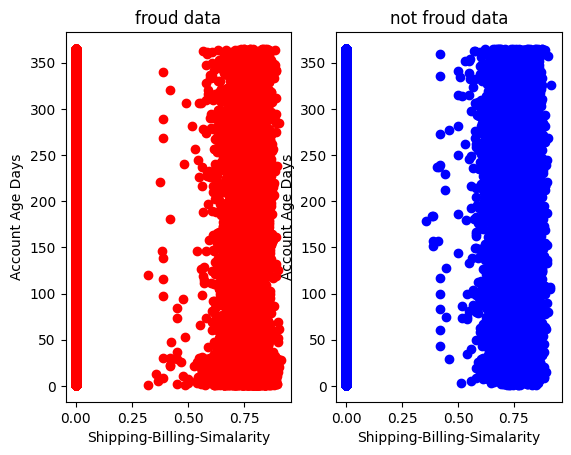

In [36]:
colors = ['blue', 'red']
data_count=len(froud_data)
x1 = list(froud_data['Shipping-Billing-Simalarity'])
y1 = list(froud_data['Account Age Days'])
x2 = list(not_froud_data['Shipping-Billing-Simalarity'])
y2 = list(not_froud_data['Account Age Days'])

fig, ax = plt.subplots(nrows=1, ncols=2)
ax[0].scatter(x1, y1, c=colors[1])
ax[0].set_title("froud data")
ax[0].set_xlabel("Shipping-Billing-Simalarity")
ax[0].set_ylabel("Account Age Days")


ax[1].scatter(x2, y2, c=colors[0])
ax[1].set_title("not froud data")
ax[1].set_xlabel("Shipping-Billing-Simalarity")
ax[1].set_ylabel("Account Age Days")



plt.show()

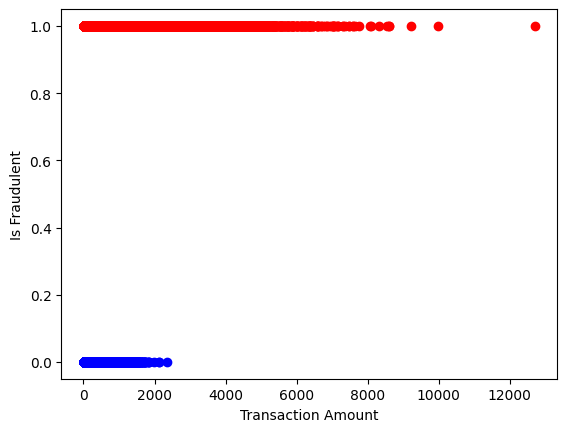

In [39]:
colors = ['blue', 'red']
data_count=len(froud_data)
x1 = list(froud_data['Transaction Amount'])
y1 = list(froud_data['Is Fraudulent'])
x2 = list(not_froud_data['Transaction Amount'])
y2 = list(not_froud_data['Is Fraudulent'])

plt.scatter(x1, y1, c=colors[1])
plt.scatter(x2, y2, c=colors[0])

plt.xlabel("Transaction Amount")
plt.ylabel("Is Fraudulent")

plt.show()

Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): 1


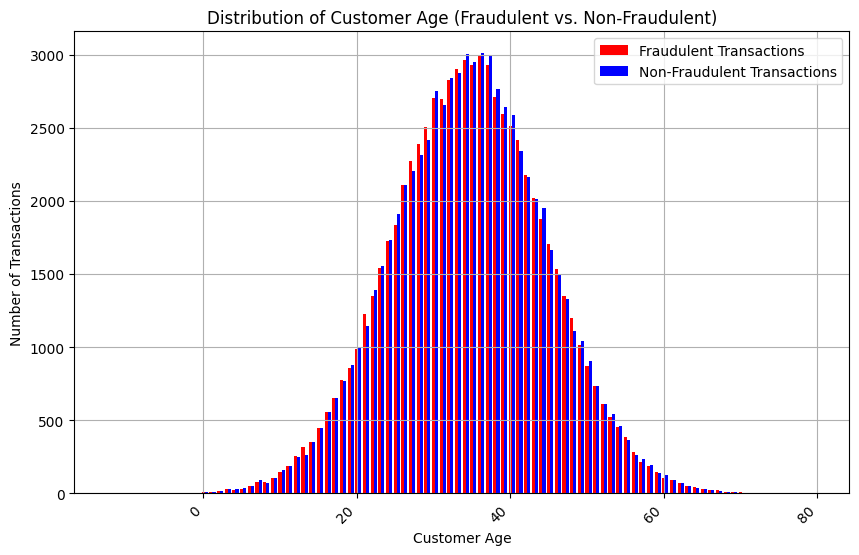

In [31]:
def analyze_transactions_by_column(data, column_name):

  # Filter fraudulent and non-fraudulent transactions
  fraudulent_transactions = data[data["Is Fraudulent"] == True]
  non_fraudulent_transactions = data[data["Is Fraudulent"] == False]

  # Ensure the column exists and is numeric
  if column_name not in data.columns or not pd.api.types.is_numeric_dtype(data[column_name]):
    raise ValueError(f"Invalid column name '{column_name}' or column is not numeric.")

  # Count the value distribution for fraudulent and non-fraudulent customers
  fraud_value_counts = fraudulent_transactions[column_name].value_counts()
  non_fraud_value_counts = non_fraudulent_transactions[column_name].value_counts()

  return fraud_value_counts, non_fraud_value_counts


def analyze_and_plot_distribution(data, column_name):

  try:
    # Analyze value distribution by column
    fraud_value_counts, non_fraud_value_counts = analyze_transactions_by_column(data.copy(), column_name)
  except ValueError as e:
    print(f"Error: {e}")
    return

  # Extract the unique values (assuming they represent categories for the column)
  unique_values = fraud_value_counts.index.tolist()

  # Plot the distribution for fraudulent and non-fraudulent customers (assuming categorical data)
  plt.figure(figsize=(10, 6))
  plt.bar(unique_values, fraud_value_counts, label="Fraudulent Transactions", width=0.4, color='red')
  plt.bar([x + 0.4 for x in unique_values], non_fraud_value_counts, label="Non-Fraudulent Transactions", width=0.4, color='blue')

  # Customize the plot
  plt.xlabel(column_name)
  plt.ylabel("Number of Transactions")
  plt.title(f"Distribution of {column_name} (Fraudulent vs. Non-Fraudulent)")
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability with many categories
  plt.legend()
  plt.grid(True)

  plt.show()


try:
  # Prompt user for column selection
  column_name = input("Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): ")
  analyze_and_plot_distribution(trainData, 'Customer Age')
except:
  print("An error occurred during analysis or plotting. Please check your data, column name, and code.")


Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): 1


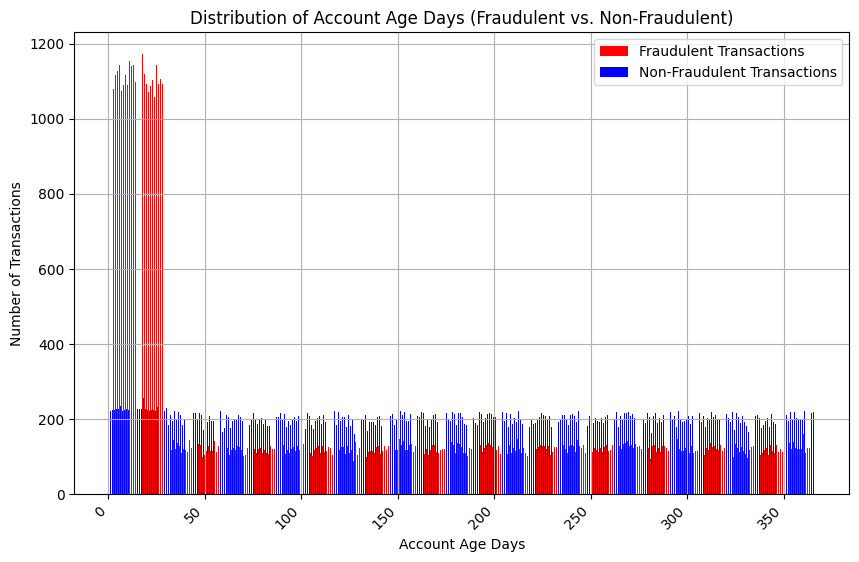

In [33]:
try:
  # Prompt user for column selection
  column_name = input("Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): ")
  analyze_and_plot_distribution(trainData, 'Account Age Days')
except:
  print("An error occurred during analysis or plotting. Please check your data, column name, and code.")

Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): 1


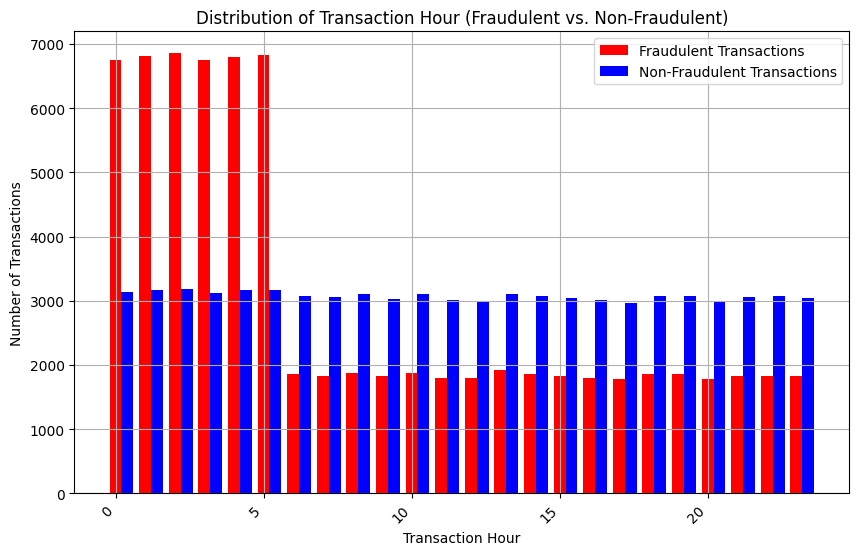

In [34]:
try:
  # Prompt user for column selection
  column_name = input("Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): ")
  analyze_and_plot_distribution(trainData, 'Transaction Hour')
except:
  print("An error occurred during analysis or plotting. Please check your data, column name, and code.")

Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): 1


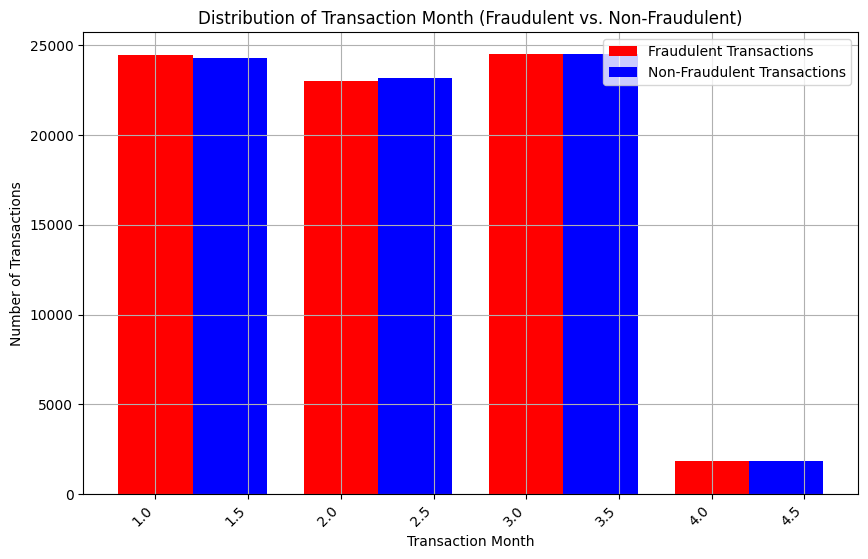

In [35]:
try:
  # Prompt user for column selection
  column_name = input("Enter the name of a numeric column to analyze (e.g., Amount, AgeCustomer): ")
  analyze_and_plot_distribution(trainData, 'Transaction Month')
except:
  print("An error occurred during analysis or plotting. Please check your data, column name, and code.")

In [35]:
trainData.head()

,Transaction Amount,Payment Method,Product Category,Quantity,Customer Age,Customer Location,Device Used,Is Fraudulent,Account Age Days,Transaction Hour,Transaction Month,Shipping-Billing-Simalarity
32,31.08,0,0,2,32,17285,2,1,147,13,1,0.000000
68,839.30,1,2,2,36,39151,1,1,65,1,3,0.000000
85,379.00,3,3,4,37,3783,0,1,30,20,1,0.000000
92,46.26,2,0,2,30,30169,2,1,12,10,1,0.000000
191,2038.00,2,2,1,32,43295,1,1,9,17,1,0.785714


Logistick Regretion

In [ ]:
LogisticModel = LogisticRegression()

In [ ]:
LogisticModel.fit(train_x,train_y)

LogisticRegression()

In [ ]:
train_prediction = LogisticModel.predict(train_x)
test_prediction = LogisticModel.predict(test_x)
train_accuracy = accuracy_score(train_prediction,train_y)
test_accuracy = accuracy_score(test_prediction, test_y)

print('train accuracy = ', train_accuracy)
print('test accuracy = ', test_accuracy)
print('froud accuracy = ', accuracy_score(LogisticModel.predict( froud_data.drop('Is Fraudulent',axis=1) ), froud_data['Is Fraudulent']))
print('not_froud accuracy = ', accuracy_score(LogisticModel.predict( not_froud_data.drop('Is Fraudulent',axis=1) ), not_froud_data['Is Fraudulent']))

train accuracy =  0.6963555350903329
test accuracy =  0.718964204112719
froud accuracy =  0.6657953899076356
not_froud accuracy =  0.7269156802730301


In [ ]:
pred_y = LogisticModel.predict(test_x)
cm = confusion_matrix(test_y, pred_y)

In [ ]:
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[16148  6264]
 [  378   844]]
Accuracy: 0.718964204112719
Precision: 0.7205068713189363
Recall: 0.9771269514704103
F1-Score: 0.829421131028815


DecisionTree

In [ ]:
DecisionTreeModel = DecisionTreeClassifier(criterion='gini',max_depth=50, min_samples_leaf=50,random_state=25)

In [ ]:
DecisionTreeModel.fit(train_x,train_y)

DecisionTreeClassifier(max_depth=50, min_samples_leaf=50, random_state=25)

In [ ]:
pred_y = DecisionTreeModel.predict(test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[17465  4947]
 [  358   864]]
Accuracy: 0.7755352458322755
Precision: 0.7792700339104052
Recall: 0.9799135947932447
F1-Score: 0.8681496209767616


In [ ]:
train_prediction = DecisionTreeModel.predict(train_x)
test_prediction = DecisionTreeModel.predict(test_x)
train_accuracy = accuracy_score(train_prediction,train_y)
test_accuracy = accuracy_score(test_prediction, test_y)

print('train accuracy = ', train_accuracy)
print('test accuracy = ', test_accuracy)
print('froud accuracy = ', accuracy_score(DecisionTreeModel.predict( froud_data.drop('Is Fraudulent',axis=1) ), froud_data['Is Fraudulent']))
print('not_froud accuracy = ', accuracy_score(DecisionTreeModel.predict( not_froud_data.drop('Is Fraudulent',axis=1) ), not_froud_data['Is Fraudulent']))

train accuracy =  0.7621482163655571
test accuracy =  0.7755352458322755
froud accuracy =  0.7164874454887727
not_froud accuracy =  0.8078089872423413


Random Forest Classifier

In [ ]:
RandomForestModel = RandomForestClassifier(max_depth=15, random_state=100)

In [ ]:
RandomForestModel.fit(train_x,train_y)

RandomForestClassifier(max_depth=15, random_state=100)

In [ ]:
pred_y = RandomForestModel.predict(test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[17386  5026]
 [  325   897]]
Accuracy: 0.7735888973512736
Precision: 0.7757451365339997
Recall: 0.98164982214443
F1-Score: 0.8666350970764898


In [ ]:
train_prediction = RandomForestModel.predict(train_x)
test_prediction = RandomForestModel.predict(test_x)
train_accuracy = accuracy_score(train_prediction,train_y)
test_accuracy = accuracy_score(test_prediction, test_y)

print('train accuracy = ', train_accuracy)
print('test accuracy = ', test_accuracy)
print('froud accuracy = ', accuracy_score(RandomForestModel.predict( froud_data.drop('Is Fraudulent',axis=1) ), froud_data['Is Fraudulent']))
print('not_froud accuracy = ', accuracy_score(RandomForestModel.predict( not_froud_data.drop('Is Fraudulent',axis=1) ), not_froud_data['Is Fraudulent']))

train accuracy =  0.8105785638830955
test accuracy =  0.7735888973512736
froud accuracy =  0.7678024865245537
not_froud accuracy =  0.8533546412416371


SVC

In [ ]:
SvcModel = SVC()

In [ ]:
SvcModel.fit(train_x,train_y)

SVC()

In [ ]:

print('froud accuracy = ', accuracy_score(SvcModel.predict( froud_data.drop('Is Fraudulent',axis=1) ), froud_data['Is Fraudulent']))
print('not_froud accuracy = ', accuracy_score(SvcModel.predict( not_froud_data.drop('Is Fraudulent',axis=1) ), not_froud_data['Is Fraudulent']))

froud accuracy =  0.623432378991847


In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
pred_y = SvcModel.predict(test_x)

In [ ]:
cm = confusion_matrix(test_y, pred_y)

In [ ]:
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[18150  4262]
 [  429   793]]
Accuracy: 0.8015147668613015
Precision: 0.80983401749063
Recall: 0.9769094138543517
F1-Score: 0.8855602449318143


In [ ]:
import pickle

In [ ]:
pickle.dump(RandomForestModel,open('/content/E-commerce-RandomForestModel-2','wb'))

In [ ]:
svc1=pickle.load(open("/content/E-commerce-SVC1", "rb"))
svc2=pickle.load(open("/content/E-commerce-Svc2", "rb"))
rf1=pickle.load(open("/content/E-commerce-RF1", "rb"))
rf2=pickle.load(open("/content/E-commerce-RF2", "rb"))

In [ ]:
pred_y = svc2.predict(test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[18150  4262]
 [  429   793]]
Accuracy: 0.8015147668613015
Precision: 0.80983401749063
Recall: 0.9769094138543517
F1-Score: 0.8855602449318143


In [ ]:
pred_y = rf2.predict(test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[17386  5026]
 [  325   897]]
Accuracy: 0.7735888973512736
Precision: 0.7757451365339997
Recall: 0.98164982214443
F1-Score: 0.8666350970764898


In [ ]:
pred_y = svc1.predict(test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[19163  3249]
 [  672   550]]
Accuracy: 0.8340949479563341
Precision: 0.8550330180260575
Recall: 0.9661204940761281
F1-Score: 0.9071886761190144


In [ ]:
pred_y = rf1.predict(test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[17550  4862]
 [  349   873]]
Accuracy: 0.7795125666412795
Precision: 0.7830626450116009
Recall: 0.9805017040058104
F1-Score: 0.87073007367716


In [ ]:
def gen_stack_data(df):
  simple_df = df.drop([ 'Product Category', 'Quantity'	,'Customer Age', 'Device Used',  'Customer Location','Transaction Month',	'Shipping-Billing-Simalarity'],axis=1)

  pred_svc1=svc1.predict(df)
  print('svc1 prediction done')
  pred_svc2=svc2.predict(simple_df)
  print('svc2 prediction done')
  pred_rf1=rf1.predict(df)
  print('rf1 prediction done')
  pred_rf2=rf2.predict(simple_df)
  print('rf2 prediction done')

  df['svc1']=pred_svc1
  print('svc1 added to df successfully')
  df['svc2']=pred_svc2
  print('svc2 added to df successfully')
  df['rf1']=pred_rf1
  print('rf1 added to df successfully')
  df['rf2']=pred_rf2
  print('rf2 added to df successfully')

  return df

In [ ]:
stacked_train_x = gen_stack_data(train_x)
stacked_test_x = gen_stack_data(test_x)

svc1 prediction done
svc2 prediction done
rf1 prediction done
rf2 prediction done
svc1 added to df successfully
svc2 added to df successfully
rf1 added to df successfully
rf2 added to df successfully
svc1 prediction done
svc2 prediction done
rf1 prediction done
rf2 prediction done
svc1 added to df successfully
svc2 added to df successfully
rf1 added to df successfully
rf2 added to df successfully


In [ ]:
stacked_train_x.to_csv("E-Commerce-Transactions-stacked-train.csv", index=False)
stacked_test_x.to_csv("E-Commerce-Transactions-stacked-test.csv", index=False)

In [ ]:
stacked_model = SVC()

In [ ]:
stacked_model.fit(stacked_train_x,train_y)

SVC()

In [ ]:
pred_y = stacked_model.predict(stacked_test_x)
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[18065  4347]
 [  378   844]]
Accuracy: 0.8000761614623001
Precision: 0.8060414063894342
Recall: 0.9795044190207667
F1-Score: 0.8843470811406191


In [ ]:
specific_cols = ['svc1', 'svc2', 'rf1', 'rf2']
pred_y = stacked_test_x[specific_cols].sum(axis=1) >= 3
pred_y = pred_y.astype(int)

In [ ]:
pred_y.head()

0    0
1    0
2    0
3    0
4    0
dtype: int64

In [ ]:
cm = confusion_matrix(test_y, pred_y)
print(cm)  # Print the confusion matrix
print("Accuracy:", (cm[0, 0] + cm[1, 1]) / sum(cm.flatten()))
print("Precision:", cm[0, 0] / (cm[0, 0] + cm[0, 1]))
print("Recall:", cm[0, 0] / (cm[0, 0] + cm[1, 0]))
print("F1-Score:", 2 * ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) * (cm[0, 0] / (cm[0, 0] + cm[1, 0])) / ((cm[0, 0] / (cm[0, 0] + cm[0, 1])) + (cm[0, 0] / (cm[0, 0] + cm[1, 0])))))

[[19516  2896]
 [  456   766]]
Accuracy: 0.8581704324278582
Precision: 0.8707835088345529
Recall: 0.9771680352493491
F1-Score: 0.9209135522838807
